---
title: Implementing the Perceptron Algorithm
author: Julia Joy
date: '2024-03-31'
image: "image.jpg"
description: "Blog Post 4: Implementing and testing the perceptron algorithm."
---

### Abstract 

In this blog post, I implemented the perceptron algorithm, a fundamental part of many machine learning models. Through a series of visualizations, I demonstrate the behavior of the perceptron algorithm on both linearly separable and non-linearly separable datasets in two dimensions, as well as multi-dimensional feature spaces. Additionally, I implemented the minibatch perceptron, exploring training efficiency compared to the regular perceptron as well as looking at loss convergence behavior. Through this process, I learned the ins and outs of the perceptron algorithm, and how it responds to different types of data. 

In [70]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part A: Perceptron Implementation 

The implementation of the perceptron algorithm itself is located in file perceptron.py. In this file I implemented the score, predict, loss, step, and grad functions:

score: Computes the scores for each data point in the feature matrix X. The formula for the ith entry of s is s[i] = <self.w, x[i]>, the cross product of the input data and the model weights. 

predict: Calculates y_hat, the predictions for each data point in the feature matrix X. y_hat takes on values of either 1 or 0, where y_hat is assigned 1 if the score >=0 , and y_hat is assigned 0 otherwise. 

loss: Computes the misclassification rate of the model by calculating the mean of all the misclassified data points. 

step: Compute one update step of the perceptron update using the feature matrix X and target vector y. 

grad: This function computes the gradient of the empirical risk. If a data point is correctly classified, it returns a gradient of 0. If a data point is misclassified, it returns the gradient of the cross product between the input data and the output. 
 

In order to check if this code is correctly working, I must perform experiments on different kinds of data. 
## Part B: Experiments 

### Linearly Separable Data:

I first visualize the data, to see how the data I am working with is indeed linearly-separable. 
I run the minimal training loop code from class notes, aiming to end with loss = 0 on linearly separable data.

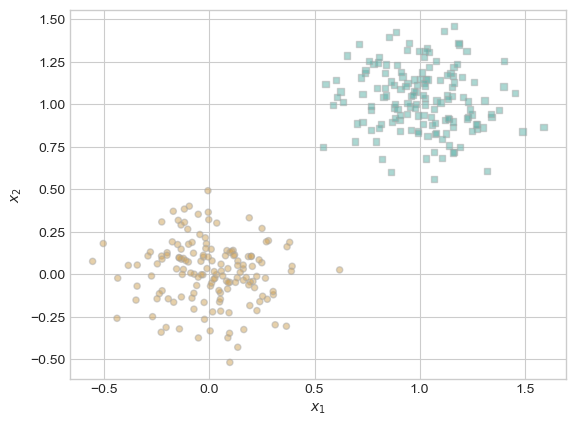

In [71]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(12345)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

We can clearly see that the data could be separated by a line, dividing the two classes, orange and blue. 

I then run the minimal training loop, and plot the evolution of the loss function.

In [72]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
lossVec = []

n = X.size()[0]

#terminates only if linearly-separable
while loss > 0: 
    loss = p.loss(X, y) 
    lossVec.append(loss)
    
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    opt.step(x_i, y_i)

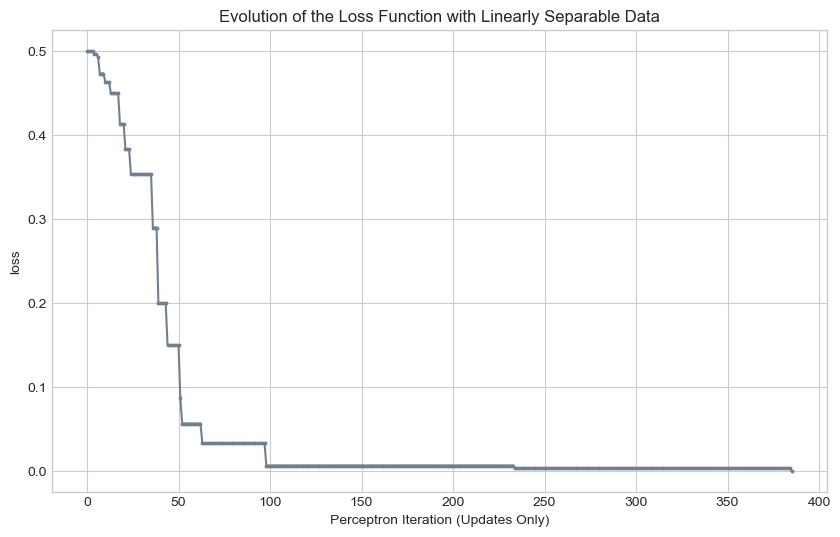

In [73]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(lossVec, color = "slategrey")
plt.scatter(torch.arange(len(lossVec)), lossVec, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Linearly Separable Data")
#check final loss value as a means of verifying model 
finalLossVal = lossVec[len(lossVec)-1]

We can see that the loss decreases after many iterations and eventually reaches 0 when running on this linearly-separable data. 

## Non-Linearly separable Data: 

We must first generate some data that we know will not be linearly separable. We can do this by editing code provided by the class notes. Non-linearly separable data means that certain data points are in the space that would normally be considered distinctly one class or another, these points are our overlapping data points. 

In [74]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
torch.manual_seed(1234)

def overlapPerceptronData(n_points = 300, noise = 0.2, p_dims = 2, numOverlap = 30):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # now generate overlapping points
    overlappingX = torch.rand(numOverlap, p_dims) * (X.max() - X.min()) + X.min()
    # add in the overlapping points to the original data points 
    overlappingX = torch.cat((overlappingX, torch.ones((numOverlap, 1))), 1)
    # generate labels for these new points 
    overlappingy = torch.ones(numOverlap, dtype=torch.bool)
    X = torch.cat((X, overlappingX), dim=0)
    y = torch.cat((y, overlappingy), dim=0)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

In order to visualize the now newly-altered, non-linearly separable data, we can plot the data as a scatterplot, also using the class notes. 

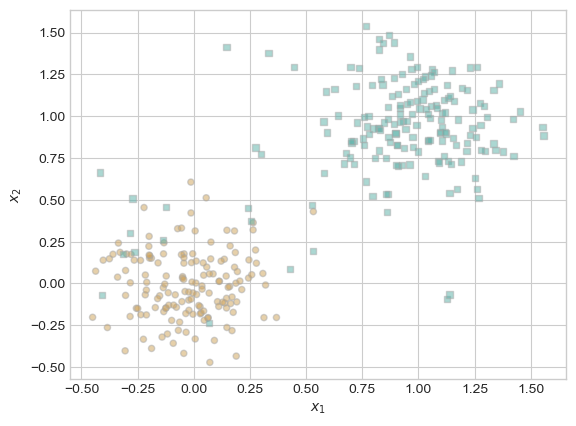

In [75]:
def plotOverlap(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")



fig, ax = plt.subplots(1, 1)
X, y = overlapPerceptronData()
nonLinPlot = plotOverlap(X, y, ax)

We can see that the overlapping of the data was successful, thus meaning that our data is no longer linearly-separable. Now we can rerun the perceptron algorithm, but since the data is not linearly separable it must be run for a certain number of iterations to ensure that the algorithm terminates. The number of iterations is set to 1000, plenty for the algorithm to run its due course. 

In [76]:
torch.manual_seed(1234)

p = Perceptron()
opt = PerceptronOptimizer(p)
X, y = overlapPerceptronData()

lossVecNLS = []

for index in range(0, 1000):
    
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = opt.step(x_i, y_i)
    loss = p.loss(X, y).item()
    lossVecNLS.append(loss)

finalWeights = opt.model.w

Now we visualize the evolution of the loss function for a non-linearly separable dataset. We can note that although the loss does decrease over iterations, it never fully reaches 0, unlike the plot of the evolution of the loss function with linearly-separable data. 

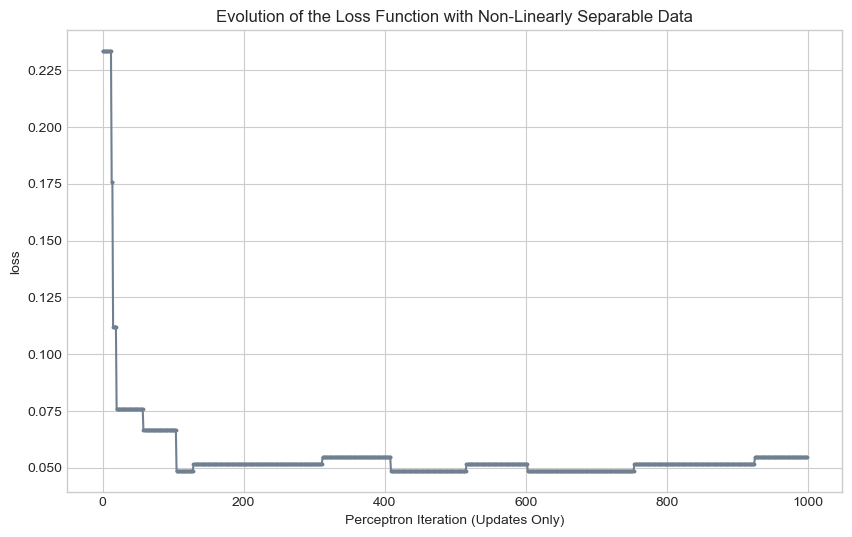

In [77]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(lossVecNLS, color = "slategrey")
plt.scatter(torch.arange(len(lossVecNLS)), lossVecNLS, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Non-Linearly Separable Data")
#check final loss value as a means of verifying model 
finalLossVal = lossVecNLS[len(lossVecNLS)-1]

Let's show the decision boundary in the final iteration, after 1000 runs of the perceptron updates. We can utilize the draw_line function from lecture to do so. 

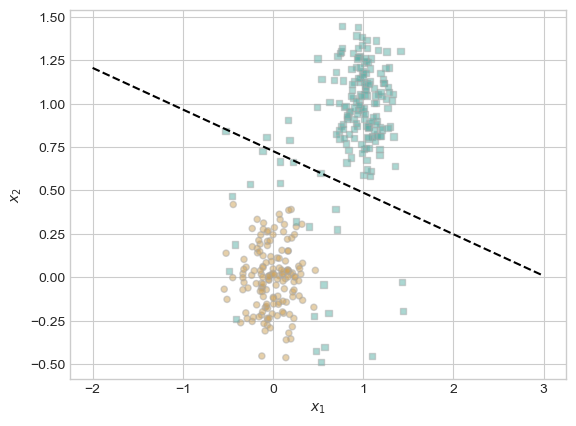

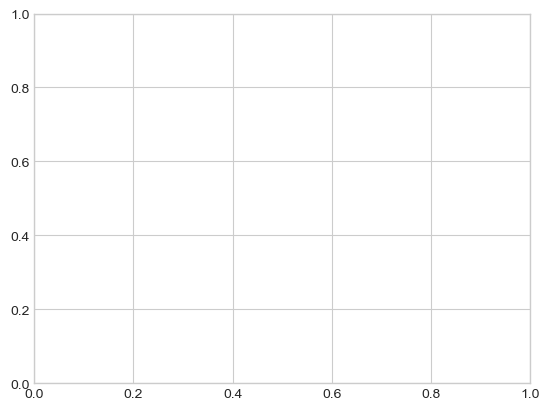

In [86]:
#function from lecture
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs) 
    fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(1, 1)
plotOverlap(X, y, ax)
draw_line(finalWeights, x_min = -2, x_max = 3, ax = ax, color = "black", linestyle = "dashed")

## Data in More Than Two Dimensions: 
The perceptron algorithm is also able to work on data with more than 2 dimensions, in this case the generated data has 5 dimensions. 
Similarly to how I did before, I rerun the perceptron algorithm, and visualize the evolution of the loss function. 

In [79]:
X, y = overlapPerceptronData(n_points = 300, noise = 0.2, p_dims = 5, numOverlap =0)

torch.manual_seed(12345)


p = Perceptron()
opt = PerceptronOptimizer(p)
X, y = overlapPerceptronData()
lossVecMD = []

for index in range(0, 1000):
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = opt.step(x_i, y_i)

    loss = p.loss(X, y).item()
    lossVecMD.append(loss)

0.05454545468091965

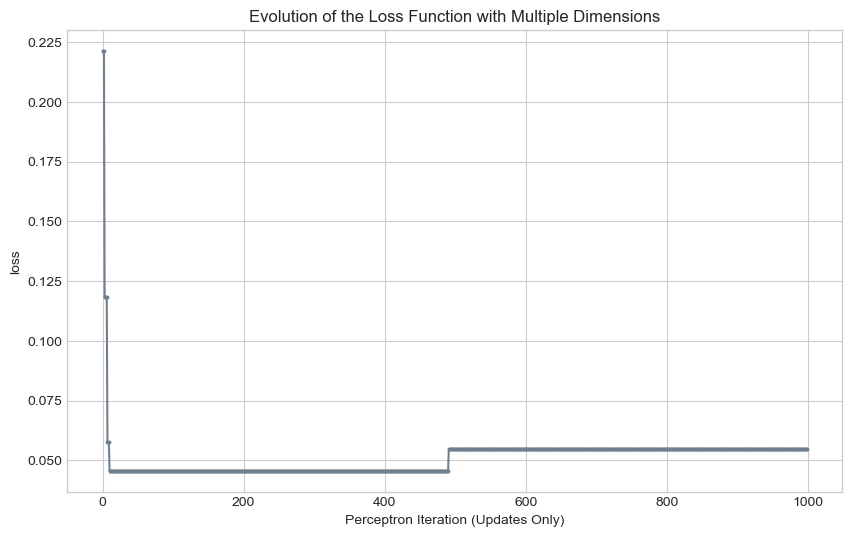

In [80]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(lossVecMD, color = "slategrey")
plt.scatter(torch.arange(len(lossVecMD)), lossVecMD, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Multiple Dimensions")
#check final loss value as a means of verifying model 
finalLossVal = lossVecMD[len(lossVecMD)-1]
finalLossVal

We can see that the loss does decrease over the iterations ran, however since the score does not fully reach zero, I believe that the data is not linearly-separable. 

### Part C: Minibatch Perceptron 

In order to implement mini-batch updating, the perceptron.grad() method needs to be updated to accept a submatrix  (of size k * p) of the feature matrix X. 
After updating, we can proceed. 


### k = 1

In [81]:
X, y = perceptron_data()

torch.manual_seed(12345) 
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
lossVecMinibatch = []

n = X.size()[0]

for index in range(0, 1000):
    loss = p.loss(X, y) 
    lossVecMinibatch.append(loss)
    
    k = 1 
    ix = torch.randperm(X.size(0))[:k]

    xSubmatrix = X[ix]
    ySubmatrix = y[ix]

    # opt step with the random submatrix
    opt.step(xSubmatrix, ySubmatrix)

tensor(0.)

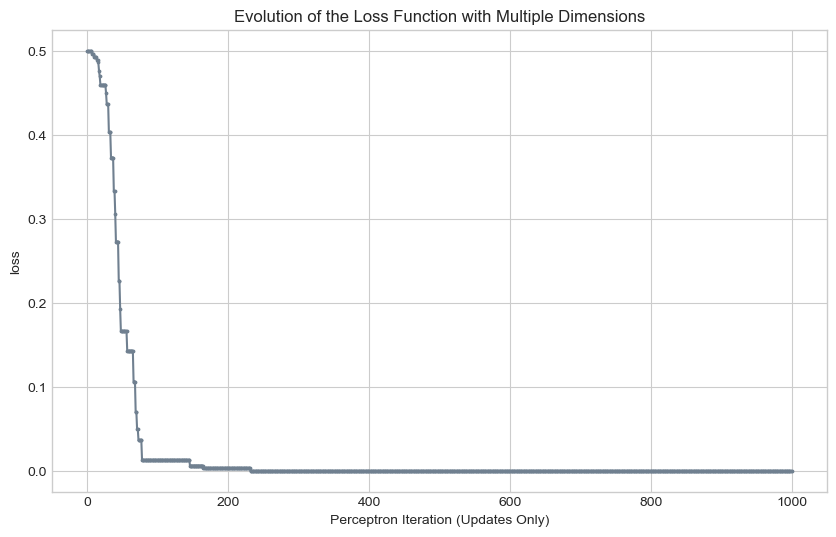

In [82]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(lossVecMinibatch, color = "slategrey")
plt.scatter(torch.arange(len(lossVecMinibatch)), lossVecMinibatch, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Multiple Dimensions")
#check final loss value as a means of verifying model 
finalLossVal = lossVecMinibatch[len(lossVecMinibatch)-1]
finalLossVal

 When k = 1, we can see that the mini-batch perceptron performs similarly to the regular perceptron on linearly separable data, as its loss eventually reaches 0. 

tensor(0.0455)

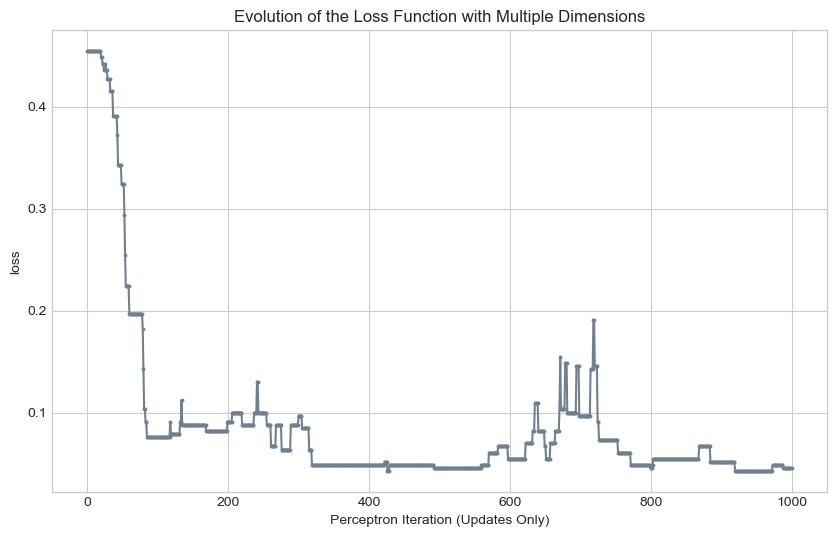

In [83]:
X, y = overlapPerceptronData()

torch.manual_seed(12345) 
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
lossVecMinibatch = []

n = X.size()[0]

for index in range(0, 1000):
    loss = p.loss(X, y) 
    lossVecMinibatch.append(loss)
    
    k = 1 
    ix = torch.randperm(X.size(0))[:k]

    xSubmatrix = X[ix]
    ySubmatrix = y[ix]

    # opt step with the random submatrix
    opt.step(xSubmatrix, ySubmatrix)


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(lossVecMinibatch, color = "slategrey")
plt.scatter(torch.arange(len(lossVecMinibatch)), lossVecMinibatch, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Multiple Dimensions")
#check final loss value as a means of verifying model 
finalLossVal = lossVecMinibatch[len(lossVecMinibatch)-1]
finalLossVal

 With non linearly-separable data, the loss does not ever fully reach 0, once again performing similarly to the regular perceptron. 
 Thus we see that when k = 1, minibatch perceptron performs similarly to regular perceptron. 

### K = 10

tensor(0.)

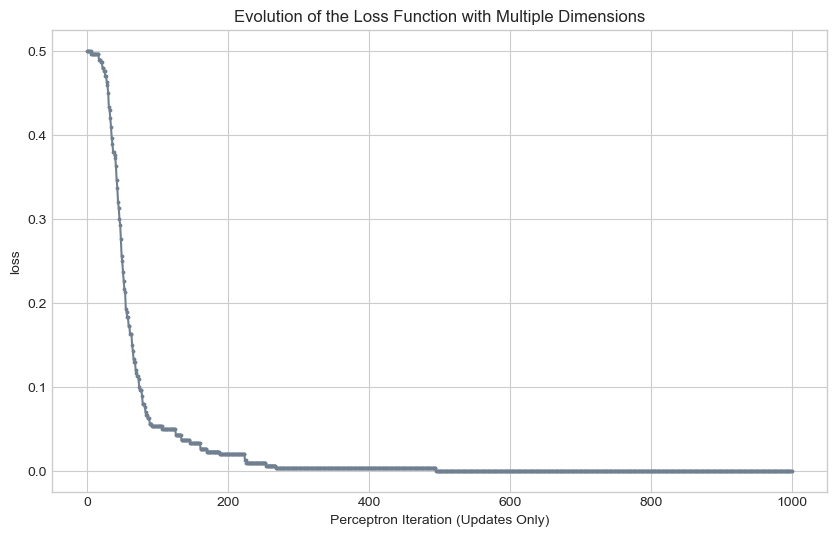

In [84]:
X, y = perceptron_data() 

torch.manual_seed(12345) 
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
lossVecMinibatch = []

n = X.size()[0]

for index in range(0, 1000):
    loss = p.loss(X, y) 
    lossVecMinibatch.append(loss)
    
    k = 10
    ix = torch.randperm(X.size(0))[:k]

    xSubmatrix = X[ix]
    ySubmatrix = y[ix]

    # opt step with the random submatrix
    opt.step(xSubmatrix, ySubmatrix)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(lossVecMinibatch, color = "slategrey")
plt.scatter(torch.arange(len(lossVecMinibatch)), lossVecMinibatch, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Multiple Dimensions")
#check final loss value as a means of verifying model 
finalLossVal = lossVecMinibatch[len(lossVecMinibatch)-1]
finalLossVal

When k = 10, we can see that minibatch perceptron can still find a separating line in 2d, as its loss eventually reaches 0. 

### K = n

tensor(0.0576)

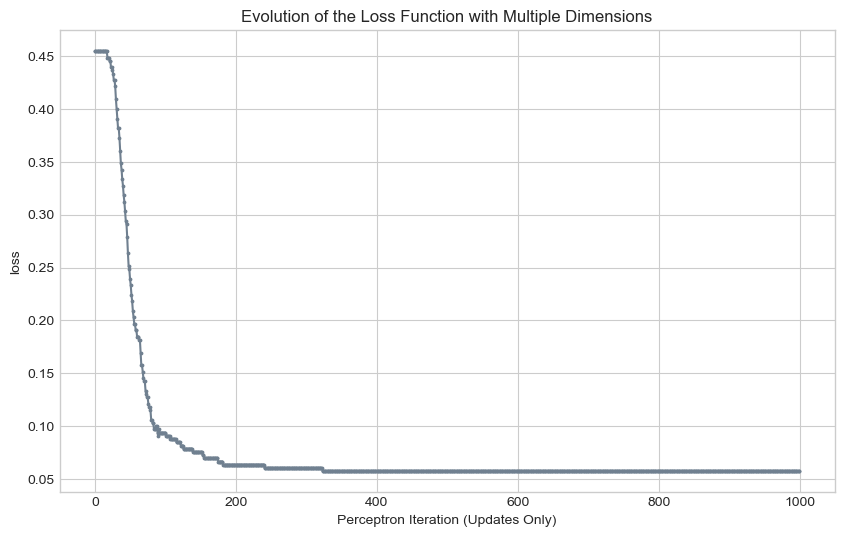

In [85]:
X, y = overlapPerceptronData() 

torch.manual_seed(12345) 
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
lossVecMinibatch = []

n = X.size()[0]

for index in range(0, 1000):

    loss = p.loss(X, y)
    lossVecMinibatch.append(loss)
    
    k = n
    ix = torch.randperm(X.size(0))[:k]

    xSubmatrix = X[ix]
    ySubmatrix = y[ix]

    # opt step with the random submatrix
    opt.step(xSubmatrix, ySubmatrix)


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(lossVecMinibatch, color = "slategrey")
plt.scatter(torch.arange(len(lossVecMinibatch)), lossVecMinibatch, color = "slategrey", s=3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title(f"Evolution of the Loss Function with Multiple Dimensions")
#check final loss value as a means of verifying model 
finalLossVal = lossVecMinibatch[len(lossVecMinibatch)-1]
finalLossVal

When k = n, meaning that the batch size the size of the entire data set, the minibatch perceptron can converge even when the data is not linearly separable, very nearly reaching a loss of 0. 

### Part D: Writing 

What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points? What about the number of features? If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?

The runtime complexity of a single iteration of the perceptron algorithm depends on the number of features (p). For each data point (represented by a row in feature matrix X), the perceptron algorithm computes the dot product the weight vector w and a row of the feature matrix X. Thus the runtime complexity of a single iteration is  O(p). 

With the minibatch perceptron, the runtime complexity of a single iteration is dependent on the size of the minibatch (k). The minibatch perceptron algorithm computes the dot product of each data point in the minibatch (rather than 1 single data point like in the typical perceptron algorithm). Thus the runtime complexity of a single iteration of the minibatch perceptron algorithm is  O(kp). 




### Summary Conclusion 


Through this exploration of the Perceptron algorithm, I have learned its behavior in functionality and response to different types of data. Experimenting with different types of data revealed the perceptron's ability to learn separating boundaries. Visualizations of evolution of the loss function allowed for easier understanding of how the algorithm itself operated, as well as revealing the differences between the behaviors of the perceptron algorithm on different types of data. I was ultimately able to successfully implement and use the perceptron algorithm for linearly separable data, non-linearly separable data, and data with more than 2 dimensions, as well as implement a version of the perceptron algorithm, the minibatch perceptron. This blog post serving as a guide to understanding the Perceptron Algorithm. 